In [1]:
%matplotlib inline
from itertools import product as c_product
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import linear_model

from disp import set_font_size
from lin_fit import fit_h


EXPT = 'CL_360_LOWFLOW_ACV'
# EXPT = 'CL_180_HighFlow_ACV'

TARGS = ['G2', 'G3', 'G4', 'G5']
SRCS = ['Odor', 'AbsHeading', 'ForVel']
NORMED_COLS = ['G2', 'G3', 'G4', 'G5', 'ForVel', 'AngVel', 'AbsAngVel', 'Heading', 'AbsHeading', 'Motion']

COLORS = {
    'G2': 'r', 'G3': 'c', 'G4': 'g', 'G5': 'm',
    'Motion': 'k', 'ForVel': 'k', 'AngVel': 'k',
}

T_WDW = [-4.5, 4.5]  # must be symmetric to ensure correct convolution
TRUNCATE = 5  # num timepoints to truncate for edge effects

DT = 0.1
T_WDW_TR = [DT * (int(T_WDW[0]/DT) + TRUNCATE), DT * (int(T_WDW[1]/DT) - TRUNCATE)]

DATA_DIR = os.path.join('data_', EXPT)
SAVE_DIR = os.path.join('data_', '_RESULTS', 'TRACKING_PREDICTION')

if not os.path.exists(SAVE_DIR):
    os.makedirs(SAVE_DIR)

# Load data and normalize

In [2]:
base = 'clean.csv'
mvng = 'moving.csv'
mvng_cols = ['Start', 'Stop']
odor = 'odor_times.csv'
odor_cols = ['Odor_On', 'Odor_Off', 'Include']

trials = []
data_u = {}  # unnormalized data
data_n = {}  # normalized data
d_mvng = {}  # dfs of moving times
d_odor = {}  # dfs of odor times

for fly in os.listdir(DATA_DIR):
    fly_path = os.path.join(DATA_DIR, fly)
    
    for trial in os.listdir(fly_path):
        trial_path = os.path.join(fly_path, trial)
        
        # load data
        data_u_ = pd.read_csv(os.path.join(trial_path, base))
        
        # store relevant columns
        data_u_ = data_u_[['Time', 'G2_avg', 'G3_avg', 'G4_avg', 'G5_avg', 'ForVel', 'AngVel', 'Heading', 'Motion']]
        data_u_['AbsAngVel'] = np.abs(data_u_['AngVel'])
        data_u_['AbsHeading'] = np.abs(data_u_['Heading'])
        
        # make odor mask
        df_odor = pd.read_csv(os.path.join(trial_path, odor))
        odor_mask = np.zeros(len(data_u_['Time']), dtype=bool)
        starts = df_odor[odor_cols[0]]
        stops = df_odor[odor_cols[1]]
        
        for start, stop in zip(starts, stops):
            odor_mask[(start <= data_u_['Time']) & (data_u_['Time'] < stop)] = True
            
        data_u_['Odor'] = odor_mask.astype(float)
        
        # make moving mask
        df_mvng = pd.read_csv(os.path.join(trial_path, mvng))
        mvng_mask = np.zeros(len(data_u_['Time']), dtype=bool)
        starts = df_mvng[mvng_cols[0]]
        stops = df_mvng[mvng_cols[1]]
        
        for start, stop in zip(starts, stops):
            mvng_mask[(start <= data_u_['Time']) & (data_u_['Time'] < stop)] = True
            
        data_u_['Mvng'] = mvng_mask
        
        data_u_ = data_u_.rename(columns={'G2_avg': 'G2', 'G3_avg': 'G3', 'G4_avg': 'G4', 'G5_avg': 'G5'})
        
        # normalize data
        data_n_ = data_u_.copy()
        data_n_[NORMED_COLS] -= data_n_[NORMED_COLS].mean()
        data_n_[NORMED_COLS] /= data_n_[NORMED_COLS].std()
        
        # store all results
        data_u[trial] = data_u_
        data_n[trial] = data_n_
        d_mvng[trial] = df_mvng
        d_odor[trial] = df_odor
        
        trials.append(trial)

# Plot trial example

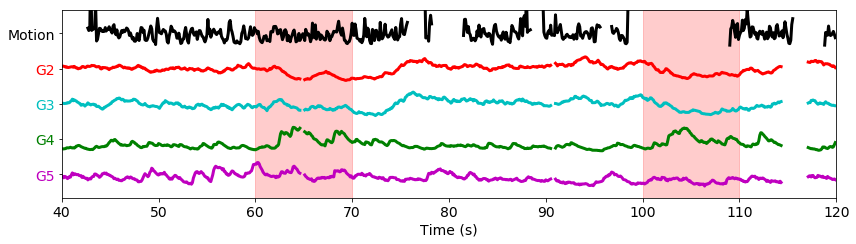

In [3]:
fig_size = (12, 3.5)
font_size = 14
trial = trials[25]
t_wdw = (40, 120)
vs = ['G2', 'G3', 'G4', 'G5']

fig, ax = plt.subplots(1, 1, figsize=fig_size, tight_layout=True)

t = data_n[trial]['Time']
t_mask = (t_wdw[0] <= t) & (t < t_wdw[1])

motion = data_n[trial]['Motion'][t_mask]
motion -= motion.min()
motion /= (.3 * motion.max())

ax.plot(t[t_mask], motion - 1.5, lw=3, c='k')

offsets = [-1.5]

for v_ctr, v in enumerate(vs):
    x = data_n[trial][v][t_mask]
    x -= x.min()
    x /= x.max()
    
    offset = -(v_ctr + 2)*1.5
    ax.plot(t[t_mask], x + offset, lw=3, c=COLORS[v])

    offsets.append(offset)
    
offsets = np.array(offsets)

df_odor = d_odor[trial]

for r_ctr, r in df_odor.iterrows():
    start = r['Odor_On']
    stop = r['Odor_Off']
    ax.axvspan(start, stop, color='r', alpha=0.2)

ax.set_xlim(t_wdw)
ax.set_ylim(-8, 0)
ax.set_yticks(offsets + 0.5)
ax.set_yticklabels(['Motion'] + vs)

for y_tick, v in zip(ax.get_yticklabels(), ['Motion'] + vs):
    y_tick.set_color(COLORS[v])

ax.set_xlabel('Time (s)')

set_font_size(ax, font_size)

# Table of odor-triggered metrics

In [9]:
WDW_G_PRE = (-2, 0)
WDW_G_POST = (4, 6)
WDW_TRACK_0 = (0, 2)
WDW_TRACK_1 = (2, 4)

def calc_metrics(trial, data, pulse, mvmt, ctl_offset):
    """Calculate metrics for each odor pulse."""
    
    p_on = pulse['Odor_On'] + ctl_offset
    p_off = pulse['Odor_Off'] + ctl_offset
    
    rslt = {}
    
    rslt['Trial'] = trial
    rslt['On'] = p_on
    rslt['Off'] = p_off
    rslt['Include'] = 'Include' if pulse['Include'] else 'Exclude'
    
    # Preliminary
    t = np.array(data['Time'])
    
    ## mvmt times
    mvng = np.zeros(len(t), dtype=bool)
    
    for m_ctr in range(len(mvmt)):
        mvmt_bout = mvmt.iloc[m_ctr]
        
        t_mask = (mvmt_bout['Start'] <= t) & (t < mvmt_bout['Stop'])
        mvng[t_mask] = True
        
        del t_mask
    
    # compute all metrics
    
    for gx in ['G2', 'G3', 'G4', 'G5']:

        ###### METRIC ######
        # dF/F GX t-avg'd before odor onset
        t_mask = (p_on+WDW_G_PRE[0] <= t) & (t < p_on+WDW_G_PRE[1])
        rslt['d_{}_{}_{}'.format(gx, *WDW_G_PRE)] = np.nanmean(np.array(data[gx])[t_mask])

        del t_mask
        
        # dF/F GX t-avg'd after odor onset
        t_mask = (p_on+WDW_G_POST[0] <= t) & (t < p_on+WDW_G_POST[1])
        rslt['d_{}_{}_{}'.format(gx, *WDW_G_POST)] = np.nanmean(np.array(data[gx])[t_mask])

        del t_mask
    
    ###### METRIC ######
    # change in abs heading post odor onset
    t_mask_0 = (p_on+WDW_TRACK_0[0] <= t) & (t < p_on+WDW_TRACK_0[1])
    t_mask_1 = (p_on+WDW_TRACK_1[0] <= t) & (t < p_on+WDW_TRACK_1[1])
    rslt['d_h'] = np.nanmean(np.abs(data['Heading'][t_mask_0])) - np.nanmean(np.abs(data['Heading'][t_mask_1]))
    
    del t_mask_0, t_mask_1
    
    # MVNG ONLY METRICS
    
    for gx in ['G2', 'G3', 'G4', 'G5']:
        
        ###### METRIC ######
        # dF/F GX t-avg'd before odor onset
        t_mask = (p_on+WDW_G_PRE[0] <= t) & (t < p_on+WDW_G_PRE[1]) & mvng
        rslt['d_{}_{}_{}'.format(gx, *WDW_G_PRE)] = np.nanmean(np.array(data[gx])[t_mask])

        del t_mask
        
        # dF/F GX t-avg'd after odor onset
        t_mask = (p_on+WDW_G_POST[0] <= t) & (t < p_on+WDW_G_POST[1]) & mvng
        rslt['d_{}_{}_{}'.format(gx, *WDW_G_POST)] = np.nanmean(np.array(data[gx])[t_mask])

        del t_mask
                                                           
    ###### METRIC ######
    # change in abs heading post odor onset
    t_mask_0 = (p_on+WDW_TRACK_0[0] <= t) & (t < p_on+WDW_TRACK_0[1]) & mvng
    t_mask_1 = (p_on+WDW_TRACK_1[0] <= t) & (t < p_on+WDW_TRACK_1[1]) & mvng
    rslt['d_h_mv'] = np.nanmean(np.abs(data['Heading'][t_mask_0])) - np.nanmean(np.abs(data['Heading'][t_mask_1]))
    
    return rslt

In [10]:
for ctl_offset in [0, -10, -20, -30]:
    metrics_dicts = []

    for trial, data_u_ in data_u.items():

        odor = d_odor[trial]
        mvmt = d_mvng[trial]

        # loop over odor pulses
        for p_ctr in range(len(odor)):
            pulse = odor.iloc[p_ctr]

            metrics_dicts.append(calc_metrics(trial, data_u_, pulse, mvmt, ctl_offset=ctl_offset))

    metrics = pd.DataFrame.from_records(metrics_dicts)
    metrics.index.name = 'Pulse'

    # re-order columns
    cols = list(metrics.columns)
    cols = [cols.pop(cols.index(col)) for col in ['Trial', 'On', 'Off', 'Include']] + cols
    metrics = metrics[cols]

    # add control vars to test stats analysis
    x_c_1, x_c_2, x_c_3, x_c_4 = np.random.normal(0, 1, (4, len(metrics)))
    y_c = x_c_1 + x_c_2 + x_c_3 + np.random.normal(0, 1, len(metrics))

    metrics['x_c_1'] = x_c_1
    metrics['x_c_2'] = x_c_2
    metrics['x_c_3'] = x_c_3
    metrics['x_c_4'] = x_c_4
    metrics['y_c'] = y_c

    if not ctl_offset:
        metrics.to_csv(os.path.join(SAVE_DIR, '{}_METRICS.csv'.format(EXPT)), na_rep='NaN')
    else:
        metrics.to_csv(os.path.join(SAVE_DIR, '{}_METRICS_FALSE_ODOR_OFFSET_{}.csv'.format(EXPT, ctl_offset)), na_rep='NaN')

/home/rkp/miniconda3/envs/sci/lib/python3.5/site-packages/ipykernel_launcher.py:79: RuntimeWarning: Mean of empty slice
/home/rkp/miniconda3/envs/sci/lib/python3.5/site-packages/ipykernel_launcher.py:54: RuntimeWarning: Mean of empty slice
/home/rkp/miniconda3/envs/sci/lib/python3.5/site-packages/ipykernel_launcher.py:71: RuntimeWarning: Mean of empty slice
/home/rkp/miniconda3/envs/sci/lib/python3.5/site-packages/ipykernel_launcher.py:65: RuntimeWarning: Mean of empty slice


In [11]:
metrics_filt = metrics[metrics['Include'] == 'Include'].dropna()

In [12]:
n_split = 1000

# fit linear model
from sklearn.linear_model import LinearRegression

df_x = metrics_filt[['d_G2_-2_0', 'd_G3_-2_0', 'd_G4_-2_0', 'd_G5_-2_0']]
x = df_x.values
df_y = metrics_filt['d_h']
y = df_y.values

n_train = int(round(.8*len(x)))
n_test = len(x) - n_train

r2_train = []
r2_test = []
coef = []

for s_ctr in range(n_split):
    rnd_prm = np.random.permutation(len(x))
    rgr = LinearRegression().fit(x[rnd_prm[:n_train], :], y[rnd_prm[:n_train]])
    
    r2_train.append(rgr.score(x[rnd_prm[:n_train], :], y[rnd_prm[:n_train]]))
    r2_test.append(rgr.score(x[rnd_prm[-n_test:], :], y[rnd_prm[-n_test:]]))
    coef.append(rgr.coef_)
    
r2_train = np.array(r2_train)
r2_test = np.array(r2_test)
coef = np.array(coef)

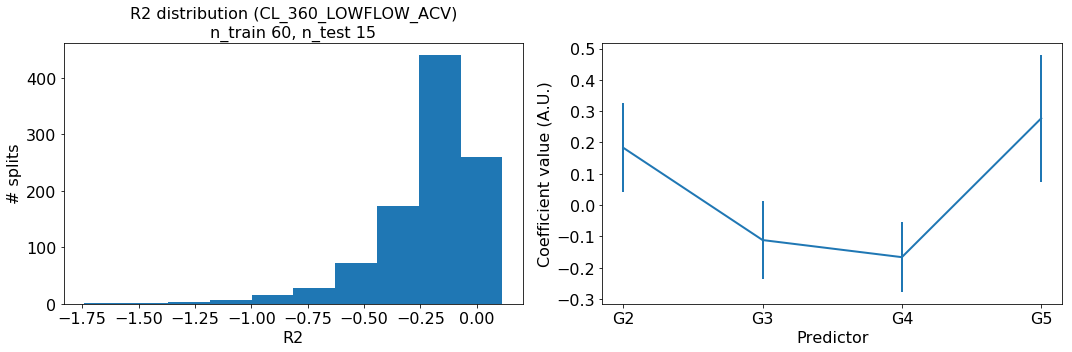

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5), tight_layout=True)
axs[0].hist(r2_test)
axs[0].set_xlabel('R2')
axs[0].set_ylabel('# splits')
axs[0].set_title('R2 distribution ({})\nn_train {}, n_test {}'.format(EXPT, n_train, n_test))

axs[1].errorbar(np.arange(coef.shape[1]), coef.mean(0), yerr=coef.std(0), lw=2)
axs[1].set_xticks(np.arange(coef.shape[1]))
axs[1].set_xticklabels(['G2', 'G3', 'G4', 'G5'])

axs[1].set_xlabel('Predictor')
axs[1].set_ylabel('Coefficient value (A.U.)')

for ax in axs:
    set_font_size(ax, 16)